In [1]:
import os
os.chdir("../")
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.factory.config_factory import cfg, show_configs, build_output
from src.factory.data_factory import DataFactory
from src.factory.data_format_factory import DataFormatFactory
from src.factory.transform_factory import TransformFactory
from src.factory.loader_factory import LoaderFactory
from src.base_data import BaseData
from tools.logger import setup_logger
from tqdm import tqdm
logger = setup_logger("./external/")

In [2]:
cfg.merge_from_file("./configs/shufflenetv2_object_detection.yml")
# build_output(cfg, "./configs/person.yml")

In [37]:
cfg.NUM_WORKERS = 1
cfg.DB.PATH = "/media/allen/mass/DB"
cfg.DB.DATA = "crowdhuman"
cfg.DB.DATA_FORMAT = "coco"
cfg.DB.TARGET_FORMAT = "centernet"
cfg.DB.LOADER = "coco"
cfg.DB.USE_TRAIN = False
cfg.DB.USE_TEST = True
cfg.INPUT.SIZE = (512, 512)
cfg.INPUT.TRAIN_BS = 1
cfg.MODEL.STRIDES = [4]
cfg.DB.TRAIN_TRANSFORM = "RandScale Tensorize"
cfg.DB.TEST_TRANSFORM = "ResizeKeepAspectRatio Tensorize"
cfg.COCO.TARGET = "original"


In [38]:
loader = LoaderFactory.produce(cfg)
branch = 'val'

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
2020-05-08 11:52:52,242 16535 coco.py INFO: => CROWDHUMAN VAL is loaded
2020-05-08 11:52:52,243 16535 coco.py INFO:   Dataset statistics:
2020-05-08 11:52:52,244 16535 coco.py INFO:   -----------------------------
2020-05-08 11:52:52,245 16535 coco.py INFO:   subset   | #id     | # images
2020-05-08 11:52:52,246 16535 coco.py INFO:   -----------------------------
2020-05-08 11:52:52,247 16535 coco.py INFO:   val    |       0 |     4368
2020-05-08 11:52:52,248 16535 coco.py INFO:   -----------------------------


In [7]:
import pycocotools.coco as coco
import json
import os
import os.path as osp
from PIL import Image
from tqdm import tqdm
import numpy as np
import shutil
import cv2
from pycocotools.cocoeval import COCOeval
from tools.centernet_utils import centernet_det_decode, centernet_det_post_process
from tools.oracle_utils import gen_oracle_map
from tools.image import get_affine_transform
from copy import deepcopy

[ 46.08 193.28 150.4  511.  ]
[127.36 179.2  219.52 498.56]
[198.4  192.   302.08 510.08]
[266.88 180.48 355.84 511.  ]
[274.56 173.44 417.92 500.48]
[347.52 177.92 511.   511.  ]


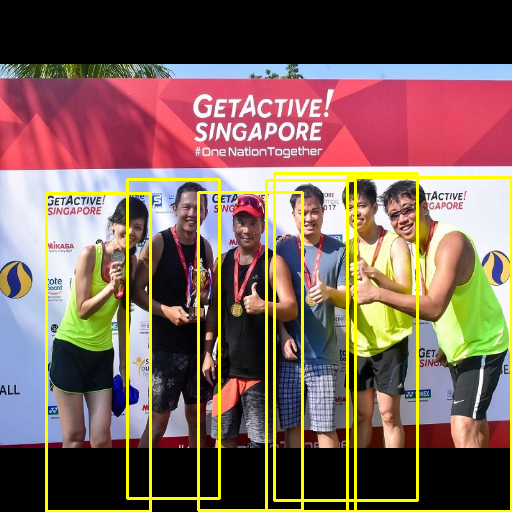

In [39]:
batch = next(iter(loader[branch]))
batch['bboxes']
bboxes = np.vstack(batch['bboxes'])
bboxes[:, [0,2]] *= 512
bboxes[:, [1,3]] *= 512
np_img = (batch['inp']*255).squeeze().permute(1,2,0).numpy().astype(np.uint8)
np_img = cv2.resize(np_img, (512,512))
Image.fromarray(np_img)
for b in bboxes:
    x1, y1, x2, y2 = b
    print(b)
    cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
Image.fromarray(np_img)

In [27]:
def _to_float(x):
    return float("{:.2f}".format(x))
    
def convert_eval_format(all_bboxes, valid_ids):
    # import pdb; pdb.set_trace()
    detections = []
    for image_id in all_bboxes:
        for cls_ind in all_bboxes[image_id]:
            for bbox in all_bboxes[image_id][cls_ind]:
                bbox[2] -= bbox[0]
                bbox[3] -= bbox[1]
                score = bbox[4]
                bbox_out  = list(map(_to_float, bbox[0:4]))
                category_id = valid_ids[cls_ind - 1]
                detection = {
                    "image_id": int(image_id),
                    "category_id": int(category_id),
                    "bbox": bbox_out,
                    "score": float("{:.2f}".format(score))
                }
                detections.append(detection)
    return detections

In [34]:
batch['s']

tensor([800.], dtype=torch.float64)

In [40]:
results = {}
normalized_detection = []
# total_dets_out
for batch in tqdm(loader[branch]):
    # bbox = batch['bboxes'][0]
    # w, h = batch['c'][0]*2
    # bbox[:,[0,2]] *= w
    # bbox[:,[1,3]] *= h
    # normalized_detection.append((bbox.numpy()))
    dets = (batch['bboxes'][0]*128).numpy()
    meta = np.zeros((dets.shape[0],2))
    meta[:,0] = 1
    dets = np.concatenate([dets, meta], axis=1)[np.newaxis, :]
    dets_out = centernet_det_post_process(
        dets=dets.copy(), 
        c=batch['c'].numpy(), 
        s=batch['s'].numpy(), 
        h=128, 
        w=128, 
        num_classes=1
    )
    break
    results[batch['img_id'][0].item()] = dets_out[0]


  0%|          | 0/4368 [00:00<?, ?it/s]

In [20]:
a = dets_out[0]
b = dets_out[0]

In [21]:
dets_out[0].update(d)

In [23]:
for cls_id in a:
    b[cls_id].extend()

{1: [[947.0, 409.25823974609375, 964.0, 461.1063232421875, 1.0]]}

In [44]:
handle = loader[branch].dataset.coco[0]
# orig_detections = convert_eval_format(results, handle.getCatIds())
# json.dump(orig_detections, open('./external/result.json', 'w'))
coco_dets = handle.loadRes('./external/result.json')
coco_eval = COCOeval(handle, coco_dets, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

Loading and preparing results...


FileNotFoundError: [Errno 2] No such file or directory: './external/result.json'

In [138]:
orig_detections[0]

{'image_id': 1,
 'category_id': 1,
 'bbox': [947.0, 406.0, -930.0, -366.0],
 'score': 1.0}

In [139]:
for orig_b, b in zip(orig_detections, detections):
    diff = np.array(orig_b['bbox']) - np.array(b['bbox'])
    print(diff)
    if diff.sum() > 0:
        print(orig_b)
        print(b)
    

412.]
[   0.    0. -406. -405.]
[   0.    0. -397. -414.]
[   0.    0. -354. -399.]
[   0.    0. -185. -410.]
[   0.    0. -186. -394.]
[   0.    0.  -53. -359.]
[   0.    0. -258. -431.]
[   0.    0. -374. -391.]
[   0.    0. -261. -402.]
[   0.    0. -448. -376.]
[   0.    0. -504. -384.]
[   0.    0. -595. -353.]
[   0.    0.  -84. -451.]
[   0.    0.  -33. -452.]
[   0.    0.   -3. -446.]
[   0.    0.  -26. -446.]
[   0.    0.  -57. -446.]
[   0.    0.  -72. -443.]
[   0.    0. -153. -355.]
[   0.    0. -345. -387.]
[   0.    0. -785. -389.]
[   0.    0. -840. -392.]
[   0.    0. -799. -392.]
[   0.    0. -112. -402.]
[   0.    0.  -96. -414.]
[   0.    0. -216. -395.]
[   0.    0. -878. -450.]
[   0.    0. -329. -432.]
[   0.    0. -505. -433.]
[   0.    0. -161. -431.]
[   0.    0. -410. -407.]
[   0.    0. -342. -414.]
[   0.    0. -308. -400.]
[   0.    0. -853. -393.]
[   0.    0.  -23. -414.]
[   0.    0.  -31. -413.]
[   0.    0.  -94. -404.]
[   0.    0. -526. -353.]
[   0.

In [134]:
diff

array([0., 0., 0., 0.])

In [29]:
img_id = batch['img_id'][0].item()
handle = loader[branch].dataset.coco[0]
fname = handle.loadImgs(ids=[img_id])[0]['file_name']
fname = os.path.join(cfg.DB.PATH, "crowdhuman", "val2017", fname)
fname

'/media/allen/mass/DB/crowdhuman/val2017/273271,c9db000d5146c15.jpg'

72.0 202.0 234.99998474121094 698.4375
199.0 180.0 343.0 679.0
310.0 200.0 471.9999694824219 697.0
417.0 182.0 556.0 698.4375
429.0 171.0 653.0 682.0
543.0 178.0 798.4375 698.4375


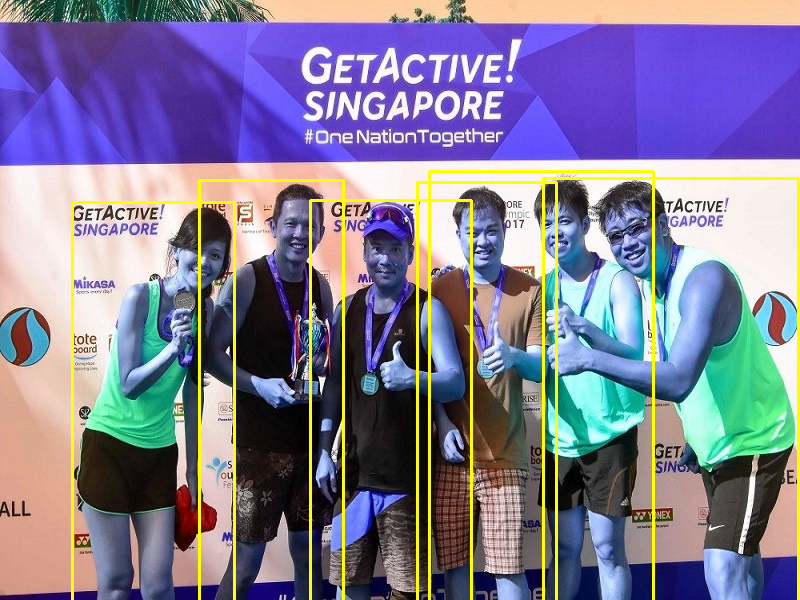

In [41]:
# np_img = (batch['inp']*255).squeeze().permute(1,2,0).numpy().astype(np.uint8)
np_img = cv2.imread(fname)
num = 0
for c in dets_out[0]:
    for b in dets_out[0][c]:
        x1, y1, x2, y2, score = b
        if score > 0.5:
            print(x1, y1, x2, y2)
            num += 1
            cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
pil_img = Image.fromarray(np_img)
w, h = pil_img.size
# print(num)
pil_img

In [13]:
def _coco_box_to_bbox(box):
    bbox = np.array([box[0], box[1], box[0] + box[2], box[1] + box[3]], dtype=np.float32)
    return bbox
ann_ids = handle.getAnnIds(imgIds=[img_id])
anns = handle.loadAnns(ids=ann_ids)
num_objs = len(anns)
src_bboxes = []
for k in range(num_objs):
    ann = anns[k]
    src_bboxes.append(_coco_box_to_bbox(ann['bbox']))

14

In [14]:
# np_img = cv2.imread(fname)
for b in src_bboxes:
    x1, y1, x2, y2 = b
    cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
Image.fromarray(np_img)

AttributeError: 'NoneType' object has no attribute '__array_interface__'

In [19]:
pil_img.size

(640, 427)

In [73]:
src = f"/media/allen/mass/deep-learning-works/evaluation/caltech cityperson cityperson/Hourglass-coco_cityperson_caltech-person-focal_l1-SGDW_cosine_lr_0.01_warmup-scratch/000-2020-04-16_10-03/results.json"
f = open(src, 'r')
results = json.load(f)

In [75]:
final = []
for result in results:
    if result['score'] > 0.5:
        final.append(result)

In [79]:
len(result)

4

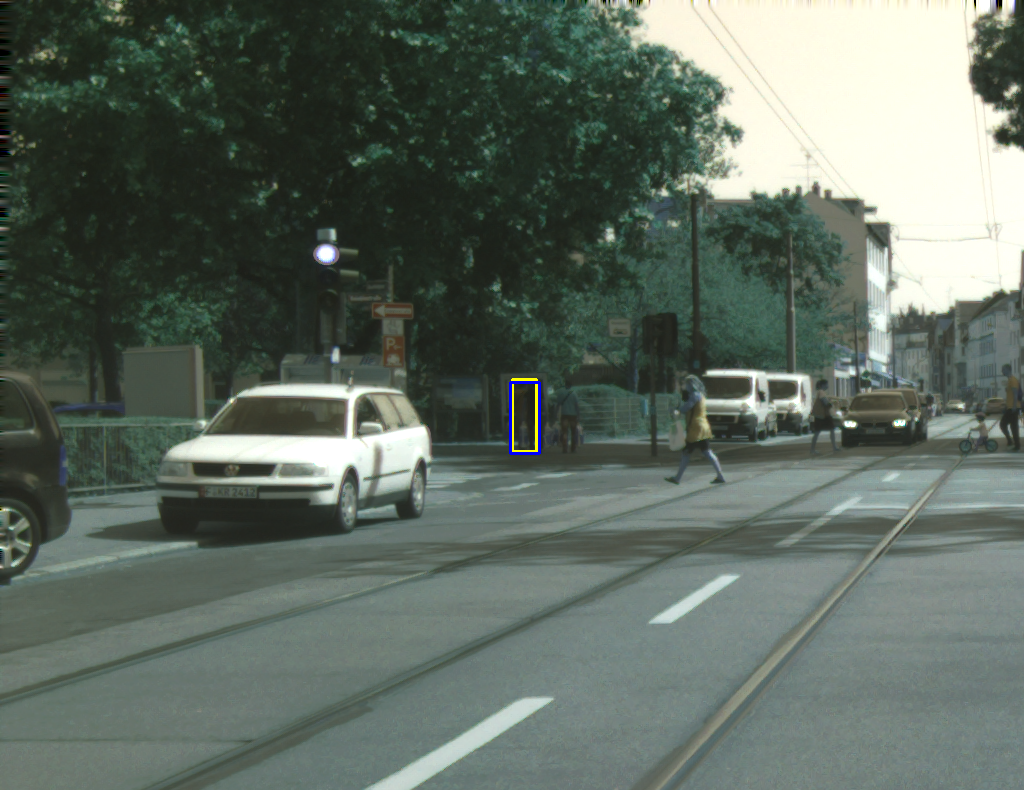

In [104]:
idx = 10
img_id = final[idx]['image_id']
handle = loader[branch].dataset.coco[0]
fname = handle.loadImgs(ids=[img_id])[0]['file_name']
fname = os.path.join(cfg.DB.PATH, "cityperson", "val2017", fname)
np_img = cv2.imread(fname)
x1, y1, w, h = final[idx]['bbox']
cv2.rectangle(np_img, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (255,255,0), 2)
x1, y1, w, h = detections[idx+3]['bbox']
cv2.rectangle(np_img, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (0,0,255), 2)
Image.fromarray(np_img)

In [12]:
handle = loader[branch].dataset.coco[0]
image_ids = handle.getImgIds()
detections = []
for img_id in image_ids:
    ann_ids = handle.getAnnIds(imgIds=[img_id])
    anns = handle.loadAnns(ids=ann_ids)
    for ann in anns:
        detection = {
            "image_id": int(img_id),
            "category_id": int(ann['category_id']),
            "bbox": ann['bbox'],
            "score": 1.0,
            'id': int(ann['id'])
        }
        detections.append(detection)
    # breakhandle = loader[branch].dataset.coco[0]
# json.dump(detections, open('./external/results.json', 'w'))
# coco_dets = handle.loadRes('./external/results.json')
# coco_eval = COCOeval(handle, coco_dets, "bbox")
# coco_eval.evaluate()
# coco_eval.accumulate()
# coco_eval.summarize()


In [15]:
len(orig_detections)

4251

In [16]:
handle = loader[branch].dataset.coco[0]
json.dump(detections, open('./external/results.json', 'w'))
coco_dets = handle.loadRes('./external/results.json')
coco_eval = COCOeval(handle, coco_dets, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.26s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.172
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10